In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from modules.StochasticProcess import StochasticProcess
from modules.BaselineWanderRemover import BaselineWanderRemover
from modules.QRSdetector import QRSdetector
from modules.ECGestimator import ECGestimator
from modules.Evaluator import Evaluator

In [91]:
sp = "a04"
data_extension = ".csv"
gt_extension = ".fqrs.txt"
data_path = "../data/set-a-text"

sp_path = os.path.join(data_path, sp+data_extension)
gt_path = os.path.join(data_path, sp+gt_extension)

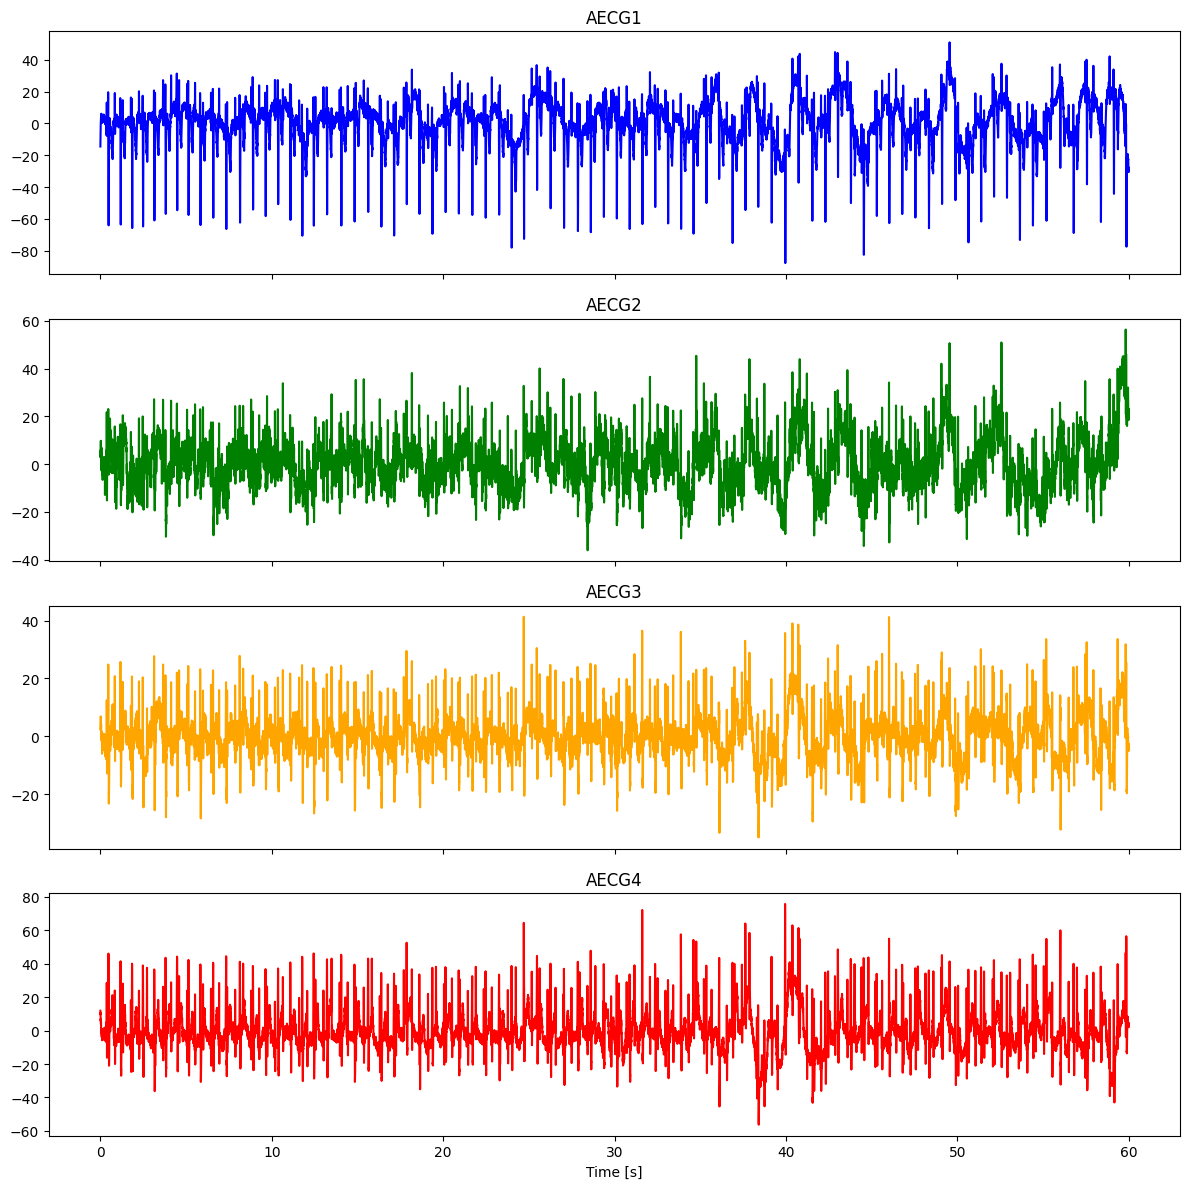

In [92]:
def extract_stochastic_process(filename, num_realizations):
    df = pd.read_csv(filename, skiprows=2, header=None)
    realizations, labels = [], []
    for i in range (1,num_realizations+1):
        AECG = df[i].to_numpy()
        AECG_cleaned = np.where(AECG == '-', '0', AECG)
        realizations.append(AECG_cleaned.astype(float))
        labels.append("AECG"+str(i))

    return realizations, labels

num_realizations = 4
realizations, labels = extract_stochastic_process(sp_path, num_realizations)
sr = 1000 
colors = ['blue', 'green', 'orange', 'red']

SP = StochasticProcess(num_realizations, realizations, labels, colors, sr)
SP.plot()

# <b>Baseline Wander Remover</b>

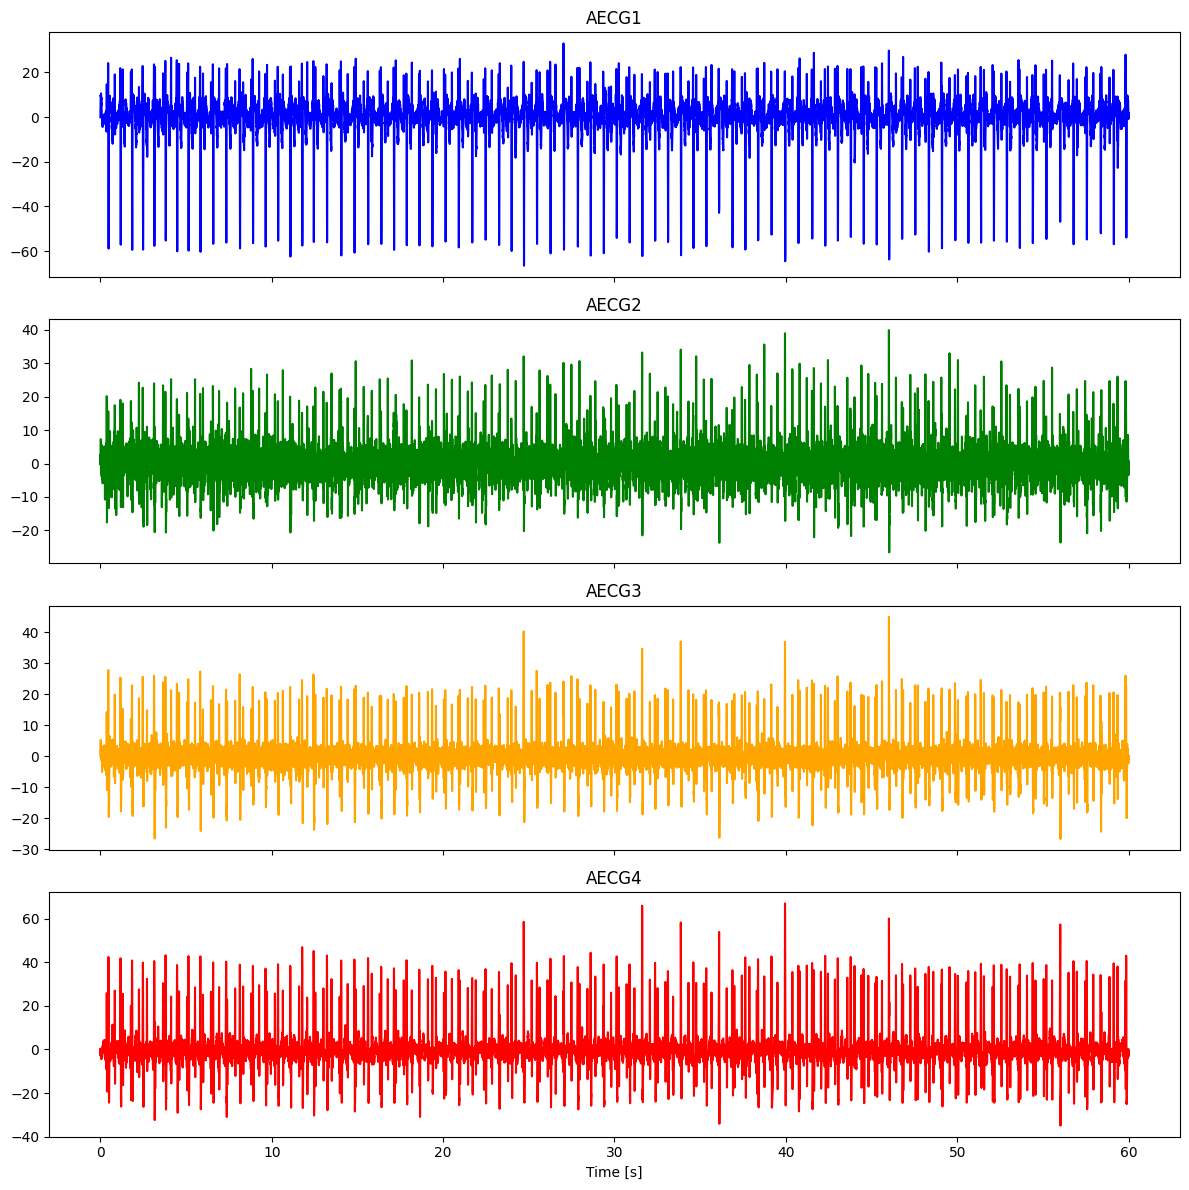

In [93]:
cutoff = 3
num_taps = 1000

bwr = BaselineWanderRemover(sr, cutoff, num_taps+1)

filtered_SP = StochasticProcess(num_realizations, [bwr.highpass_fir_filter(r) for r in SP], labels, colors, sr)

filtered_SP.plot()

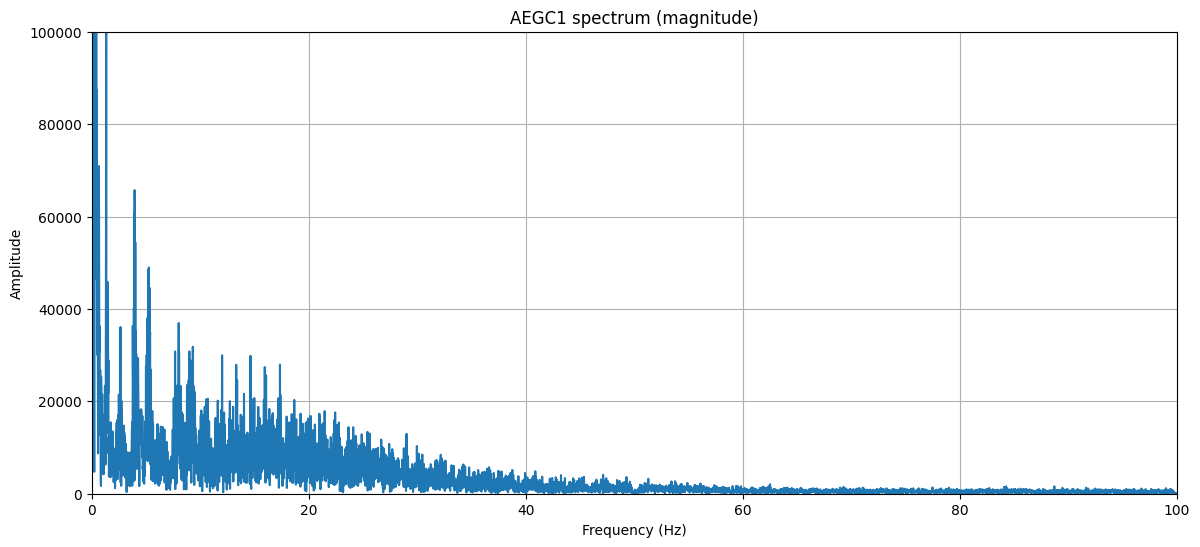

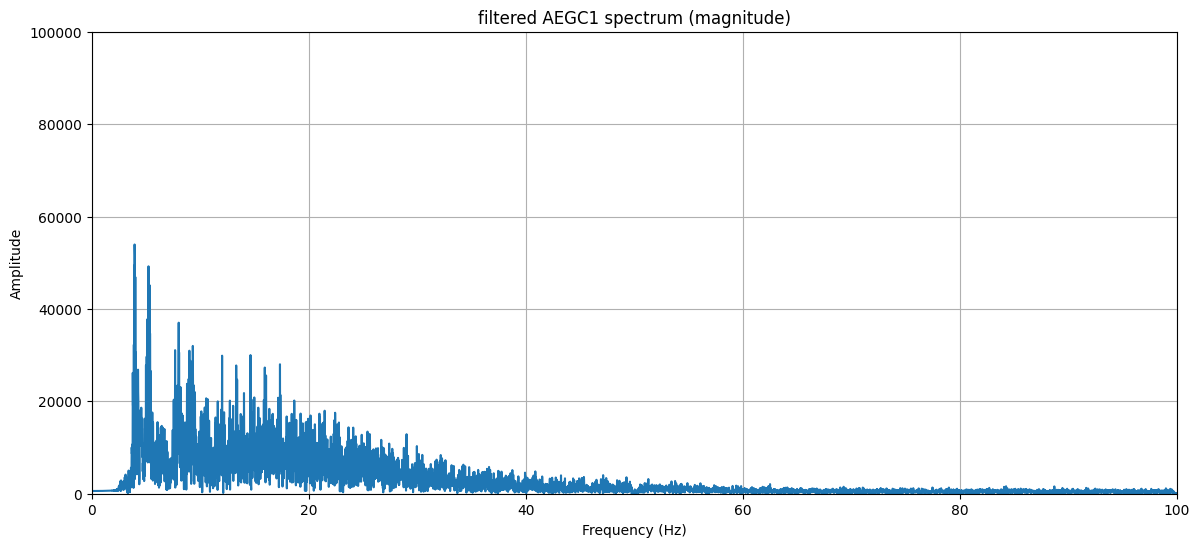

In [94]:
SP.plot_realization_spectrum(0, "AEGC1 spectrum (magnitude)")
filtered_SP.plot_realization_spectrum(0, "filtered AEGC1 spectrum (magnitude)")

# <b>Power-line interference canceller</b>

per ora troppo complicato, inoltre sembra che gli ECG del dataset abbiano già un filtraggio notch intorno ai 50 Hz per la rimozione della PLI. TODO:
- implementare il metodo ottimizzato proposto nel paper (top)
- implementare il metodo proposto dal paper, semplificato (accettabile)
- usare un notch filter a 50 Hz (brutto)

# **Upsampling**

È sufficiente un upsampling 2X per ottenre la frequenza di campionamento utilizzata nel paper (2000 Hz)

In [95]:
upsample_factor = 2
new_sr = sr * upsample_factor

upsampled_SP = filtered_SP.resample_process(new_sr)
upsampled_time = upsampled_SP.timestamps

# **Maternal QRS Detector**



### **1) QRS enhancement method**

L'idea è quella di sfruttare la forte correlazione tra le componenti QRS dei vari segnali e la bassa correlazione tra il rumore che li caratterizza, assumendo che ciascuna realizzazione del processo sia caratterizzata da queste due componenti.
Passaggi:

1. Normalizzazione dei canali, dividendo ciascun canale per la sua norma Euclidea
2. Applicazione della PCA sui canali
3. estrazione della prima componente come ECG con complessi QRS rafforzati

Questa procedura genera un segnale $\tilde{x}$ associato alla componente con maggiore varianza



In [96]:
maternal_template_duration = 0.10
maternal_threshold_factor = 0.5

MQRS_detector = QRSdetector(upsampled_SP, maternal_template_duration, maternal_threshold_factor, new_sr)
maternal_enhanced_QRS, maternal_explained_variance = MQRS_detector.get_enhanced_QRS()

Explained variance of PC1 (Maternal QRS): 57%


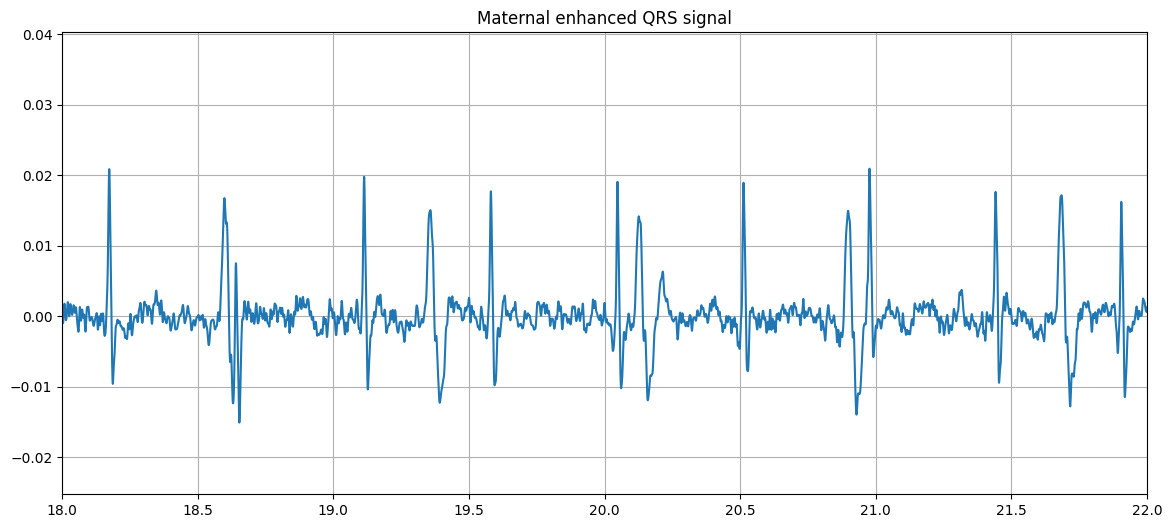

In [97]:
print(f"Explained variance of PC1 (Maternal QRS): {round(maternal_explained_variance)}%")
plt.figure(figsize=(14, 6))
plt.plot(upsampled_time, maternal_enhanced_QRS)
plt.title('Maternal enhanced QRS signal')
plt.xlim(18, 22)
plt.grid(True)
plt.show()

### **2) QRS detection method**

L'idea qui è quella di usare un template QRS $h(t)$ e di calcolare la cross-correlazione $R_{\tilde{x},h}(τ)$ con il segnale $\tilde{x}$.

I massimi locali (picchi) di $R_{\tilde{x},h}(τ)$ saranno salvati in un vettore `R = [r1, r2, ... , rN]` che identificherà le N posizioni dei picchi QRS della madre

In [98]:
maternal_qrs_template = MQRS_detector.create_qrs_template(maternal_enhanced_QRS)

Maternal QRS template length in samples: 200


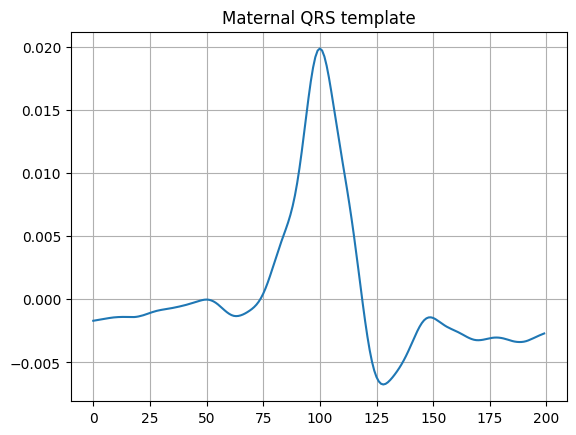

In [99]:
print(f"Maternal QRS template length in samples: {len(maternal_qrs_template)}")
plt.plot(maternal_qrs_template)
plt.title('Maternal QRS template')
plt.grid(True)
plt.show()

In [100]:
maternal_peaks, maternal_cross_corr = MQRS_detector.detect_qrs(maternal_enhanced_QRS, maternal_qrs_template)

QRS peaks detected: 55, with correlation threshold factor: 50 %


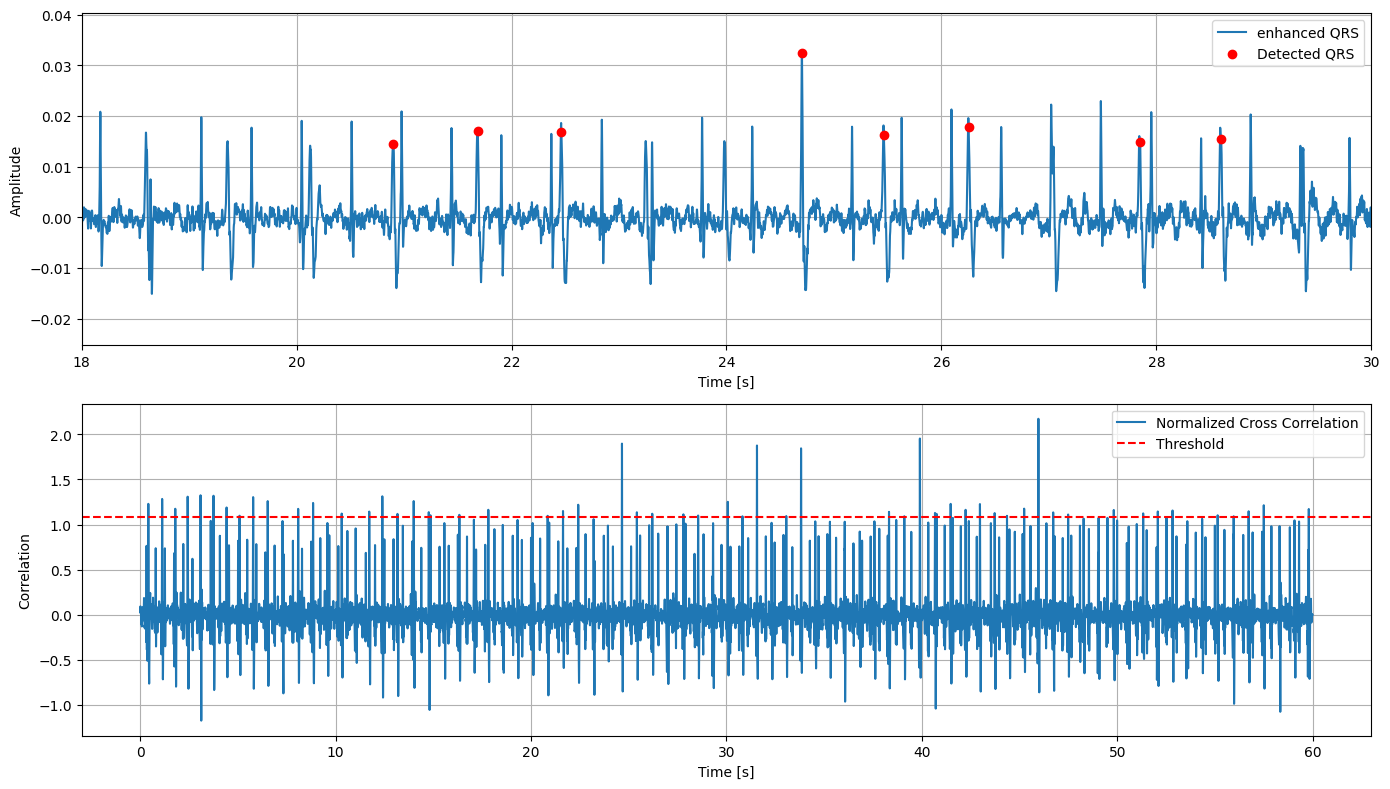

In [101]:
def plot_correlation_data(cross_corr, peaks, gt_peaks, threshold_factor, time, enhanced_QRS, gt=False):
    corr_max = np.max(cross_corr)
    print(f"QRS peaks detected: {len(peaks)}, with correlation threshold factor: {round(threshold_factor*100)} %")
    if gt: print(f"QRS peaks (ground truth): {len(gt_peaks)}")
    
    plt.figure(figsize=(14, 8))

    # Enhanced QRS (with detected peaks)
    plt.subplot(2, 1, 1)
    plt.plot(time, enhanced_QRS, label="enhanced QRS")
    plt.scatter(time[peaks], enhanced_QRS[peaks], color='red', label="Detected QRS", zorder=2)
    if gt: plt.scatter(upsampled_time[gt_peaks], enhanced_QRS[gt_peaks], color='orange', label="Ground Truth QRS peaks", zorder=2)

    plt.legend()
    plt.xlabel("Time [s]")
    plt.xlim(18, 30)
    plt.ylabel("Amplitude")
    plt.grid()

    # Cross-correlation
    plt.subplot(2, 1, 2)
    plt.plot(time[:len(cross_corr)], cross_corr, label="Normalized Cross Correlation")
    plt.axhline(y=threshold_factor*corr_max, color='red', linestyle='--', label="Threshold")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Correlation")
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_correlation_data(maternal_cross_corr, maternal_peaks, [], maternal_threshold_factor, upsampled_time, maternal_enhanced_QRS)

# **Maternal ECG Canceller**

Una porzione di MECG è definita nel seguente modo:
- *P wave:* 0.20 s
- *QRS complex:* 0.10 s
- *T wave:* 0.40 s


### **1) MECG identification**

L'MECG è identificato attraverso un metodo basato su finestratura: si costruisce una finestra centrata nel picco del complesso QRS secondo le caratteristiche sopra descritte.
La finestra avrà una durata di 1.40 s, di cui
- 0.25 prima del picco QRS
- 0.45 dopo il picco QRS

In [102]:
maternal_P_wave_duration = 0.20
maternal_T_wave_duration = 0.40

MECG_estimator = ECGestimator(upsampled_SP, maternal_P_wave_duration, maternal_template_duration, maternal_T_wave_duration, new_sr, labels)

In [103]:
real_MECGs, real_MECGs_positions = MECG_estimator.get_real_ECGs(maternal_peaks)

### **2) Average MECG**

Sia $x$ il segnale di partenza, ovvero dato dalla somma di ECG materno, ECG fetale e rumore
Viene estratto un complesso MECG medio $μ$ effettuando la media sugli N complessi MECG estratti da $x$ attraverso finestratura.

In [104]:
MECG_averages = MECG_estimator.get_ECG_averages(real_MECGs)

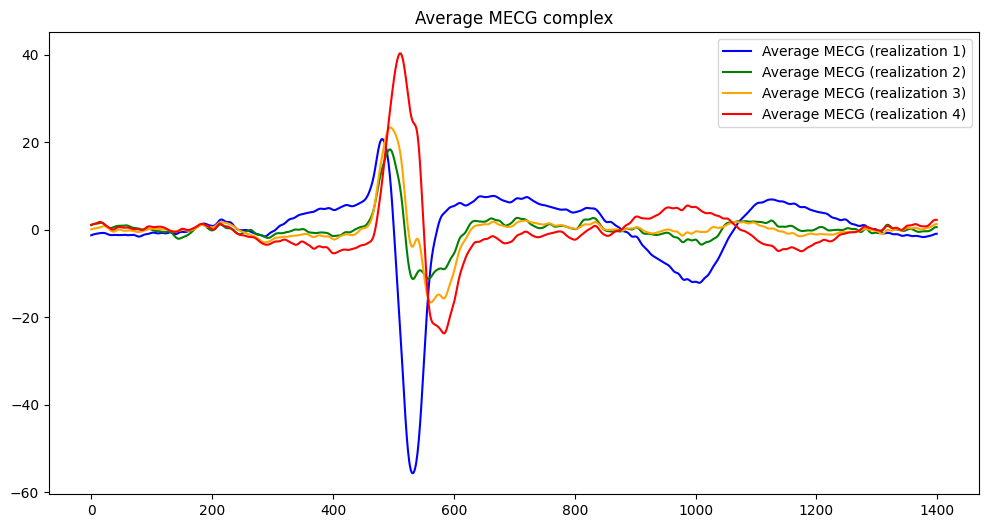

In [105]:
plt.figure(figsize=(12, 6))
for i in range(num_realizations): plt.plot(MECG_averages[labels[i]], color=colors[i], label=f"Average MECG (realization {i+1})")
plt.legend()
plt.title("Average MECG complex")
plt.show()

### **3) MECG Scaling & Subtraction using MSE minimization**

L'MECG estratto $μ$ viene risuddiviso nelle sue tre componenti:
- $\mu_{QRS} →$ contiene il complesso QRS
- $\mu_P →$ contiene l'onda P
- $\mu_T →$ contiene l'onda T

L'idea è la seguente: per ogni complesso MECG appartenente ad $x$, $\mu_{QRS}$, $\mu_P$ e $\mu_T$ vengono oppurtunamente scalati attraverso tre distinti fattori, rispettivamente $a_{QRS}$, $a_P$ e $a_T$, in modo tale che il complesso MECG medio $\mu$ matchi esattamente con il complesso MECG reale $m$.

Facendo ciò si ottiene una stima più accurata del singolo complesso MECG. Questa stima, chiamata $\hat{m}$, è definita come segue:

\begin{align*}
    \hat{m} = Ma
\end{align*}

dove $a$ è l'array contenente i tre fattori di scaling
\begin{bmatrix}
a_P\\
a_{QRS}\\
a_T
\end{bmatrix}

e $M$ è una matrice quadrata 3x3 avente le tre componenti di $\mu$ sulla diagonale:

\begin{bmatrix}
\mu_P & 0 & 0\\
0 & \mu_{QRS} & 0\\
0 & 0 & \mu_T
\end{bmatrix}

Ora, dal momento che il sample rate a questo punto della procedura è pari a 2000 Hz:
- la lunghezza di $\mu_P$ è $0.20 s \times 2000 Hz = 400$ campioni
- la lunghezza di $\mu_{QRS}$ è $0.10 s \times 2000 Hz = 200$ campioni
- la lunghezza di $\mu_T$ è $0.40 s \times 2000 Hz = 800$ campioni

Dunque $M$ in versione esplicita può essere rappresentata come:

\begin{bmatrix}
\mu_P[0] & 0 & 0\\
\mu_P[1] & 0 & 0\\
... & 0 & 0\\
\mu_P[399] & 0 & 0\\
0 & \mu_{QRS}[0] & 0\\
0 & \mu_{QRS}[1] & 0\\
0 & ... & 0\\
0 & \mu_{QRS}[199] & 0\\
0 & 0 & \mu_T[0]\\
0 & 0 & \mu_T[1]\\
0 & 0 & ...\\
0 & 0 & \mu_T[799]\\
\end{bmatrix}


Per trovare $a$, viene minimizzato l'$MSE$ tra il complesso MECG stimato $\hat{m} = Ma$ e il reale complesso MECG $m$:

\begin{align*}
    \hat{a} = argmin_{a}||Ma - m||² = argmin_{a}(ϵ²)
\end{align*}

derivando e ponendo la il risultato della derivazione uguale a 0, si ottiene:

\begin{align*}
    \hat{a} = (M^TM)^{-1}M^Tm
\end{align*}

$\hat{a}$ conterrà i valori (scalari) di scaling associati alle tre componenti del complesso, che poi verranno moltiplicati per $\mu$ (componente per componente) in modo tale da ottenere il complesso ECG materno stimato $m$

In [106]:
mu_portions = MECG_estimator.get_mu_portions(MECG_averages)

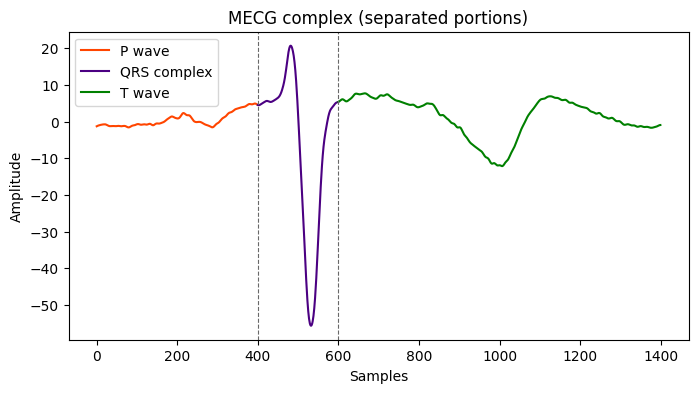

In [107]:
# plot of the three portions of mu for a single realization, just as an example
mu = mu_portions["AECG1"]

x1 = np.arange(len(mu[0]))
x2 = np.arange(len(mu[1])) + len(mu[0])
x3 = np.arange(len(mu[2])) + len(mu[0]) + len(mu[1])

plt.figure(figsize=(8, 4))

plt.plot(x1, mu[0], label="P wave", color='orangered')
plt.plot(x2, mu[1], label="QRS complex", color='indigo')
plt.plot(x3, mu[2], label="T wave", color='green')

plt.axvline(len(mu[0]), color='dimgrey', linewidth=0.8, linestyle='--')
plt.axvline(len(mu[0]) + len(mu[1]), color='dimgrey', linewidth=0.8, linestyle='--')

plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("MECG complex (separated portions)")
plt.legend()
plt.show()

In [108]:
M_matrixes = MECG_estimator.get_M_matrixes(mu_portions)

estimated_MECGs = MECG_estimator.get_estimated_ECGs(real_MECGs, M_matrixes, mu_portions)

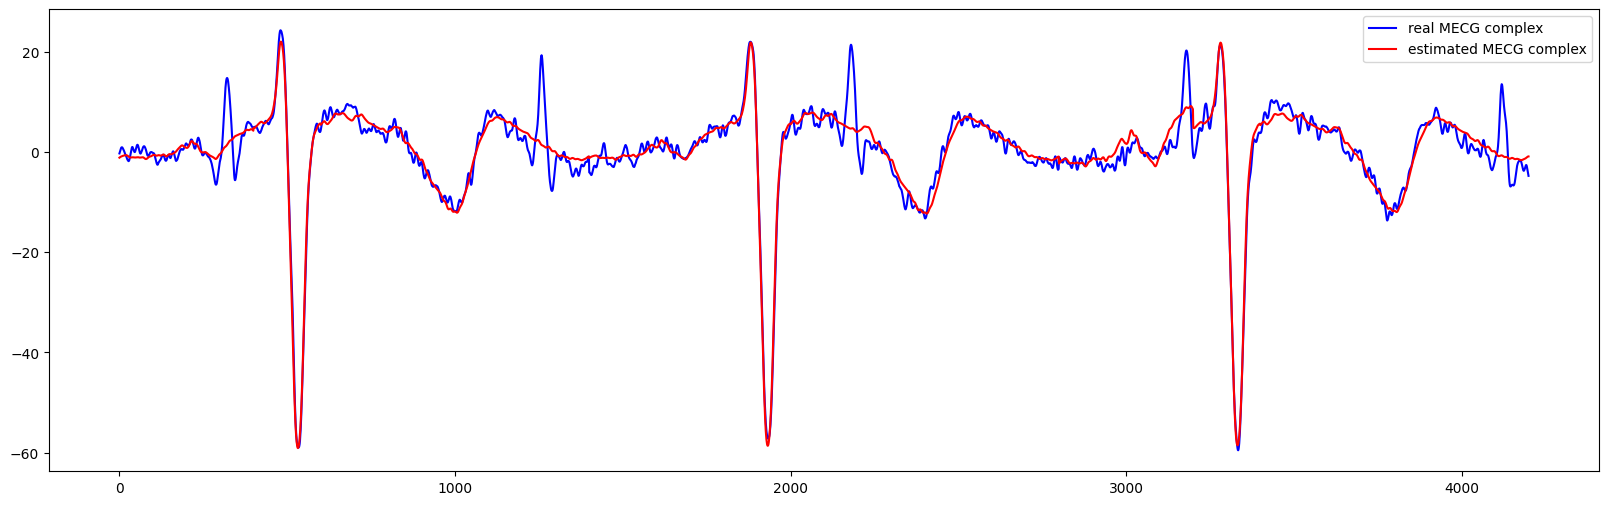

In [109]:
# comparison between first three real (blue) and estimated (red) MECGs for the first realization, just as an example
first_three_reals_MECGs = np.concatenate([real_MECGs["AECG1"][0], real_MECGs["AECG1"][1], real_MECGs["AECG1"][2]])
first_three_estimated_MECGs = np.concatenate([estimated_MECGs["AECG1"][0], estimated_MECGs["AECG1"][1], estimated_MECGs["AECG1"][2]])

plt.figure(figsize=(20, 6))
plt.plot(first_three_reals_MECGs, color='blue', label="real MECG complex")
plt.plot(first_three_estimated_MECGs, color='red', label="estimated MECG complex")
plt.legend()
plt.show()

In [110]:
def cancel_MECG(original_realization, ECG_positions, real_ECGs, estimated_ECGs):
    """
    Subtracts the estimated ECGs of the original realization from the real ECGs
    
    Args:
        original_realization (array): the realization where the estimated ECGs have to be subtracted

        ECGs_positions (dict): contains a list of the positions of the actual K ECG complexes (centered on QRS peaks) for each realization of the process
                real_ECGs_positions["AECGi"] -> [(start_ECG_i_1, end__ECG_i_1), ..., (start_ECG_i_K, end__ECG_i_K)], for i in (0, num_realizations)

        real_ECGs (dict): contains a list of the actual K ECG complexes (centered on QRS peaks) for each realization of the process
                real_ECGs["AECGi"] -> [[ECG_i_1], [ECG_i_2], ..., [ECG_i_K]],   for i in (0, num_realizations)

        estimated_ECGs (dict): contains a list of the estimated K ECG complexes (centered on QRS peaks) for each realization of the process
            estimated_ECGs["AECGi"] -> [[estimated_ECG_i_1], [estimated_ECG_i_2], ..., [estimated_ECG_i_K]],   for i in (0, num_realizations)

    Returns:
        residual_realization (array): original_realization where the ECG complexes have been cancelled
        
    """
    residual_realization = original_realization.copy()
    K = len(ECG_positions)
    for i in range(K):
        start_i_complex, end_i_complex = ECG_positions[i][0], ECG_positions[i][1]
        residual = real_ECGs[i] - estimated_ECGs[i]
        residual_realization[start_i_complex:end_i_complex] = residual
    return residual_realization

In [111]:
residual_realizations = []

for i in range(num_realizations):
    label = labels[i]
    residual_realizations.append(cancel_MECG(upsampled_SP.get_realization_by_index(i), real_MECGs_positions[label], real_MECGs[label], estimated_MECGs[label]))

residual_SP = StochasticProcess(num_realizations, residual_realizations, labels, colors, new_sr)

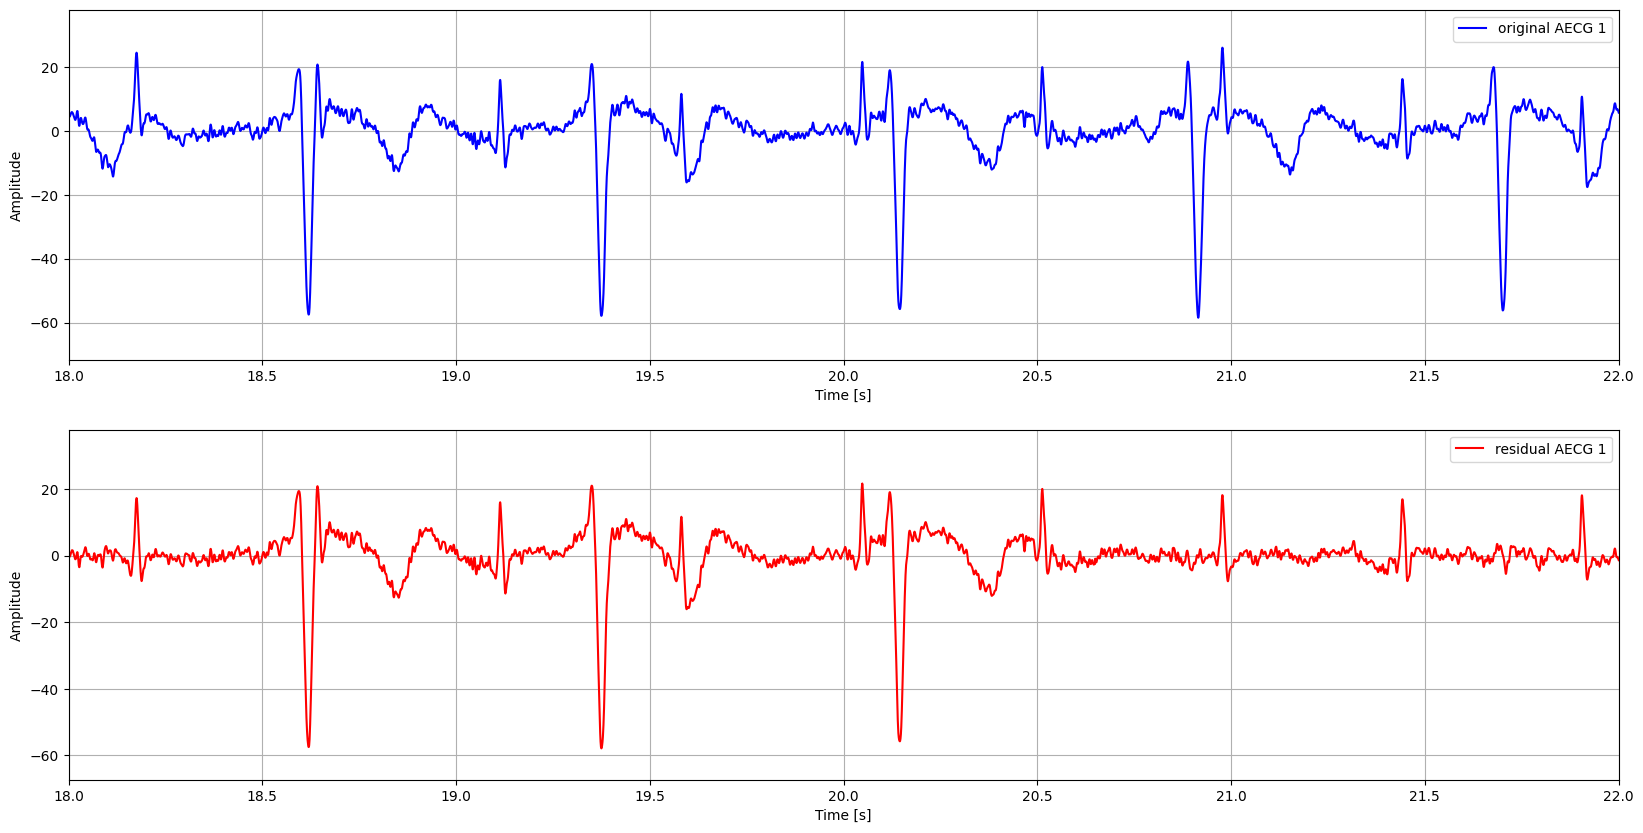

In [112]:
# Comparison between the first original realization (MECG + FECG + noise) and the first residual realization (FECG + noise), just as an example
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(upsampled_time, upsampled_SP.get_realization_by_index(0), color='blue', label="original AECG 1")
plt.legend()
plt.xlabel("Time [s]")
plt.xlim(18, 22)
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(upsampled_time, residual_SP.get_realization_by_index(0), color='red', label="residual AECG 1")
plt.legend()
plt.xlabel("Time [s]")
plt.xlim(18, 22)
plt.ylabel("Amplitude")
plt.grid()

plt.show()

# **Fetal QRS Detector**

la procedura è la stessa usata per l'ECG materno:

processo stocastico → enhanced_QRS → QRS_template → correlazione tra QRS_template e enhanced_QRS

In [125]:
# fetal peaks (ground truth)
with open(gt_path, 'r') as file: gt = np.array([int(line.strip()) for line in file])

# adapting to new sample rate
gt_fetal_peaks = gt * upsample_factor

In [126]:
# empirically, with this value for the fetal QRS the estimated peaks are pretty close to the ground truth peaks
fetal_duration_template = 0.0935
fetal_threshold_factor = 0.15

FQRS_detector = QRSdetector(residual_SP, fetal_duration_template, fetal_threshold_factor, new_sr)

fetal_enhanced_QRS, fetal_explained_variance = FQRS_detector.get_enhanced_QRS()
print(f"Explained variance of PC1 (Fetal QRS) : {round(fetal_explained_variance)}%")

Explained variance of PC1 (Fetal QRS) : 58%


In [127]:
fetal_QRS_template = FQRS_detector.create_qrs_template(fetal_enhanced_QRS)

Fetal QRS template length in samples: 186


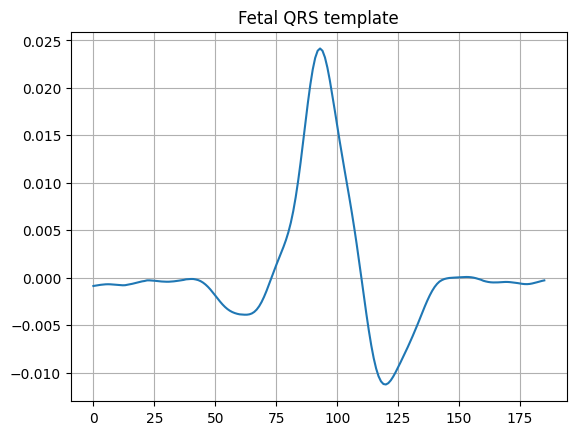

In [128]:
print(f"Fetal QRS template length in samples: {len(fetal_QRS_template)}")
plt.plot(fetal_QRS_template)
plt.title('Fetal QRS template')
plt.grid(True)
plt.show()

In [129]:
fetal_peaks, fetal_cross_corr = FQRS_detector.detect_qrs(fetal_enhanced_QRS, fetal_QRS_template)

QRS peaks detected: 63, with correlation threshold factor: 15 %
QRS peaks (ground truth): 129


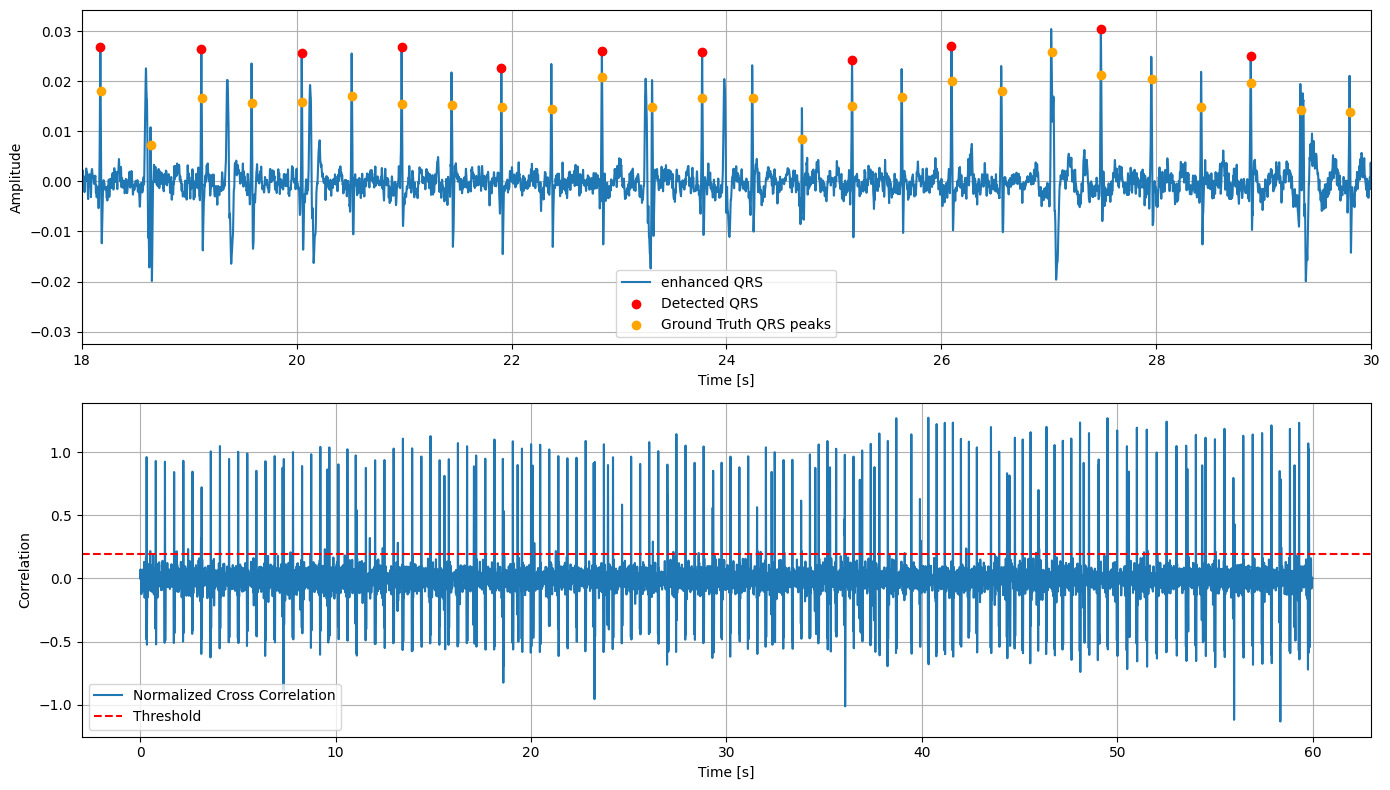

In [130]:
plot_correlation_data(fetal_cross_corr, fetal_peaks, gt_fetal_peaks, fetal_threshold_factor, upsampled_time, fetal_enhanced_QRS, gt=True)

# **Fetal ECG Detector**

Il procedimento è lo stesso utilizzato sopra: una volta estrapolati i picchi vengono estratte le finestre associate ai complessi ECG fetali e vengono mediate, in modo tale da ottenere una stima del complesso ECG fetale per ciascuna realizzazione

In [119]:
fetal_P_wave_duration = 0.20
fetal_T_wave_duration = 0.40

FECG_estimator = ECGestimator(residual_SP, fetal_P_wave_duration, fetal_duration_template, fetal_T_wave_duration, new_sr, labels)

real_FECGs, _ = FECG_estimator.get_real_ECGs(fetal_peaks)
gt_FECGs, _ = FECG_estimator.get_real_ECGs(gt_fetal_peaks)

FECG_averages = FECG_estimator.get_ECG_averages(real_FECGs)
gt_FECG_averages = FECG_estimator.get_ECG_averages(gt_FECGs)

# **Metriche di valutazione**
Utilizzate per confrontare quanto, per ciascuna realizzazione, il complesso ECG fetale medio calcolato sui picchi QRS stimati si avvicina al complesso ECG fetale medio calcolato sui picchi QRS di ground truth

- **Correlazione**: per avere una misura più qualitativa della forma dell'FECG
- **Errore quadratico medio**: valutare la differenza quantitativa in termini di ampiezza dei due complessi ECG

In [120]:
evaluator = Evaluator(FECG_averages, gt_FECG_averages)

correlations, mean_correlation = evaluator.get_correlations()
MSEs, mean_MSE = evaluator.get_MSEs()


--------------------------------AECG1--------------------------------

Correlation value for realization AECG1 = 0.8088379232018136

MSE per realizzazione AECG1 = 1.4593225437787547



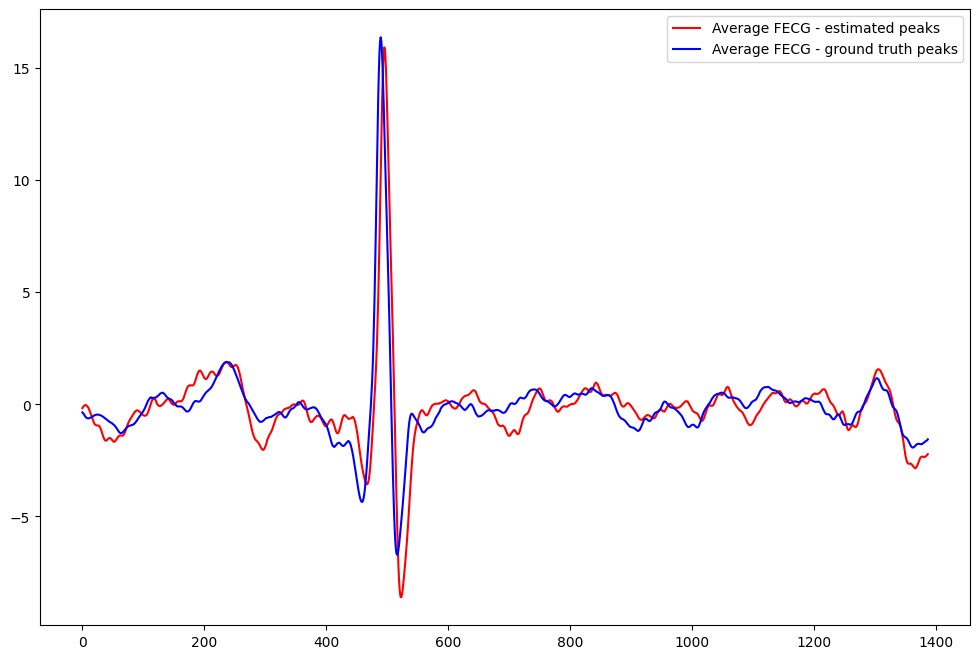


--------------------------------AECG2--------------------------------

Correlation value for realization AECG2 = 0.8079312392074622

MSE per realizzazione AECG2 = 2.352791441089956



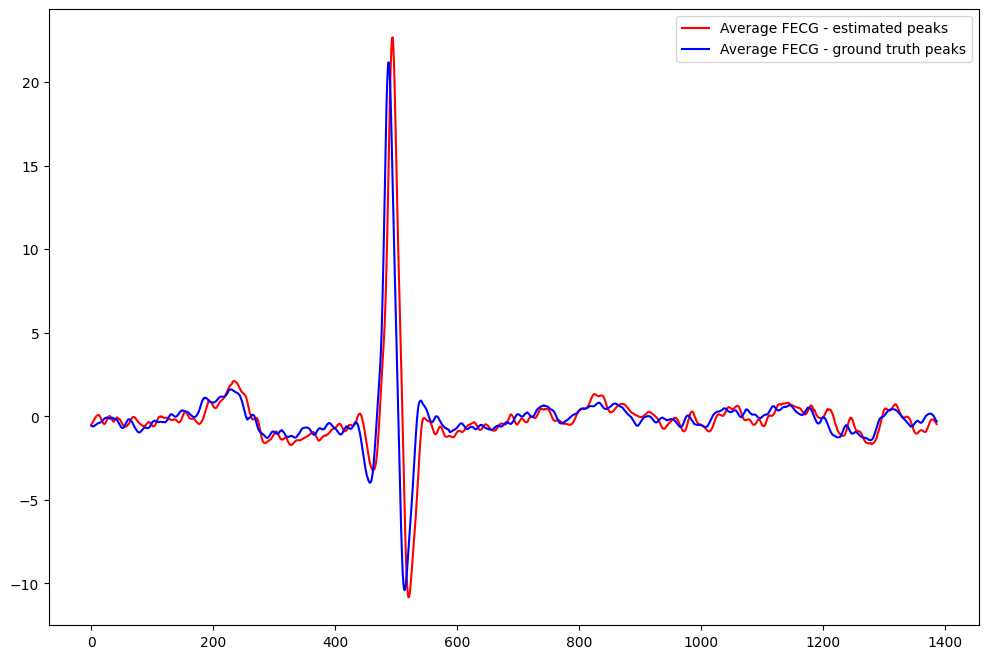


--------------------------------AECG3--------------------------------

Correlation value for realization AECG3 = 0.7967593491025502

MSE per realizzazione AECG3 = 1.8128327164390639



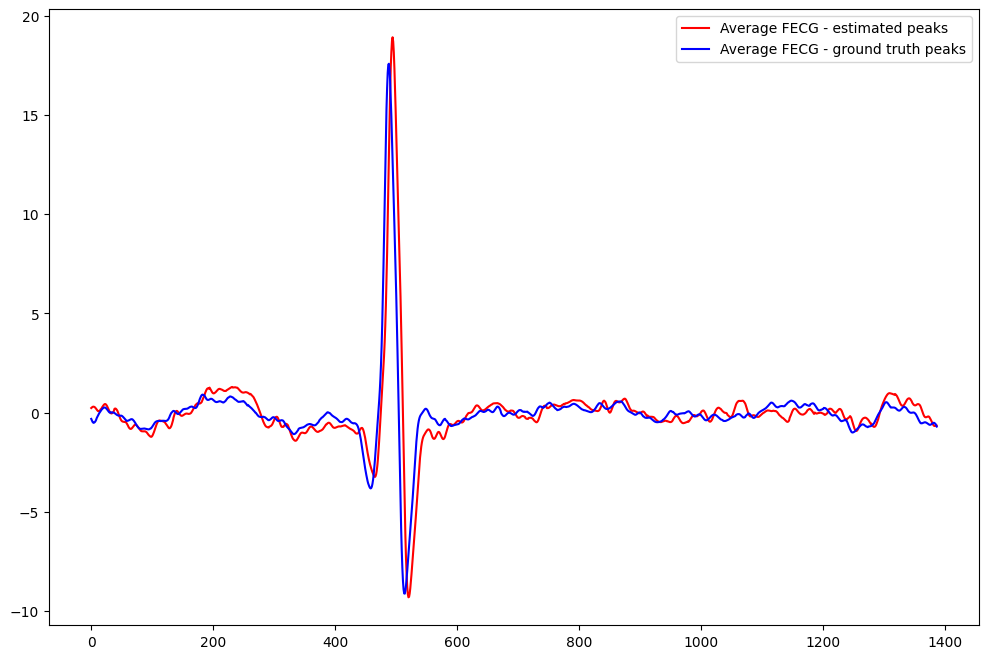


--------------------------------AECG4--------------------------------

Correlation value for realization AECG4 = 0.7988598435649684

MSE per realizzazione AECG4 = 5.001180858629573



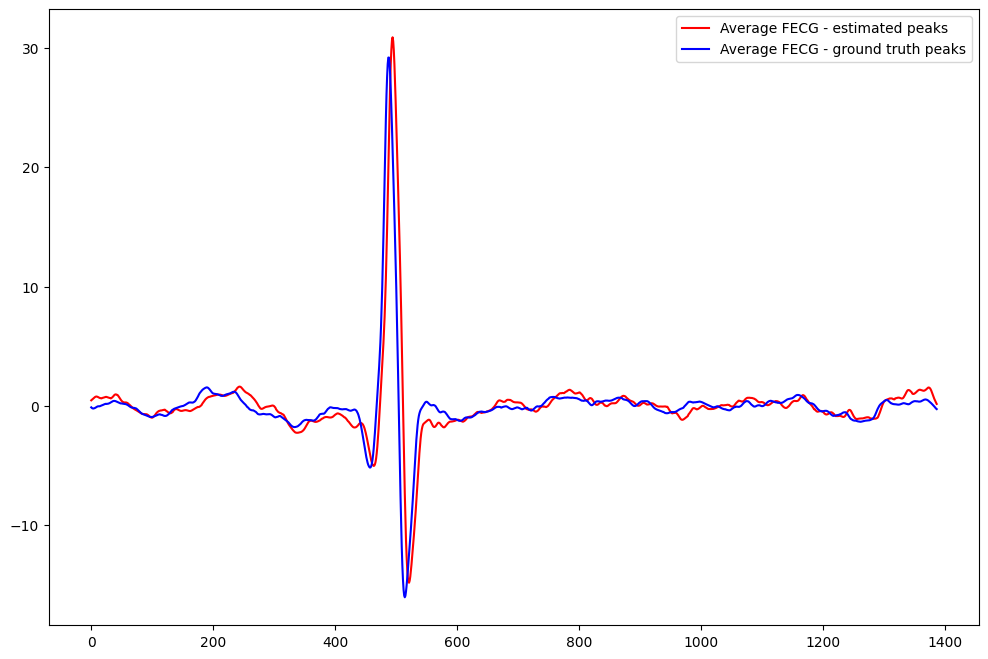

In [121]:
evaluator.plot_comparison(correlations, MSEs)

In [132]:
print(f"Average final correlation: {round(mean_correlation, 2)*100}%")
print(f"Average final MSE: {round(mean_MSE, 2)}")

Average final correlation: 80.0%
Average final MSE: 2.66


# **Misurazione Performance**

#### 1) *Valutazione del FHR*
come riferimento del fetal heart rate (FHR) abbiamo i picchi di ground truth: se i picchi di groud truth sono, ad esempio, 120, vuol dire che è stato misurato empiricamente che il cuore del feto batteva a 120 bpm. 
Per misurare la qualità del FHR estratto bisogna applicare il QRS detection method ad un segnale contenente l'ECG fetale ottenuto con un metodo diverso rispetto a quello dell'approccio sequenziale. Dunque:
- SP -> BW_Remover -> [PLI_remover] -> **ICA** -> ICx -> QRS_detection -> ICA_peaks
- SP -> sequential_approach -> sequential_peaks

Quale dei due si avvicina di più a ground truth per ciascuna realizzazione? 